In [1]:
%load_ext autoreload
# to make modification in .py file type %autoreload

%load_ext line_profiler
#for finding out how long code takes to run
#an example of how to get diagnostics on functions
#%lprun -f ff.generate_map_full ff.generate_map_full(384, A_BB, alpha_BB, beta_sigma, freqs, nu0)

In [2]:
#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize

import emcee
print(emcee.__version__)

import corner

Populating the interactive namespace from numpy and matplotlib
3.0rc2


In [12]:
#------parameters--------
A = 1.7e3
alpha = -3.0
beta = -3.2
gamma = -2.5
ells = np.arange(384) #corresponds to nside of 128
freqs = np.linspace(30, 300, 10)*1.e9
input_params = [A, alpha, beta, gamma]
in_model = ff.model(ells, freqs, input_params)
#create a filepath to store different power spectra
filepath = '/Users/alex/Documents/foreground_moments/power_spectra/'

In [4]:
#make some data
# start=time.time()
# data = ff.ps_data(ells, freqs, input_params)
# save(filepath + 'reference_ps.npy', data)
# print(time.time()-start)
data = load(filepath + 'reference_ps.npy')

In [273]:
%autoreload

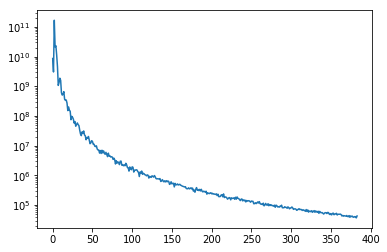

In [5]:
semilogy(data[0])

In [15]:
#the log likelihood for our stuff is simply the chi2 with cosmic variance errors
#find the placement of maximum likelihood
start=time.time()
soln = minimize(ff.chi2, input_params, args=(ells, freqs, data), 
                   method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (-6.0, -2.01)))
print(soln)
A_ml, alpha_ml, beta_ml, gamma_ml = soln.x
print(time.time()-start)

      fun: 3786.7882754442758
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.67524377,  0.00427463,  0.26734597, -0.10854819])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 65
      nit: 10
   status: 0
  success: True
        x: array([1700.00004345,   -3.01404202,   -3.19334862,   -2.4408515 ])
22.19039011001587


In [17]:
x0 = soln.x
fit0 = ff.model(ells, freqs, x0)

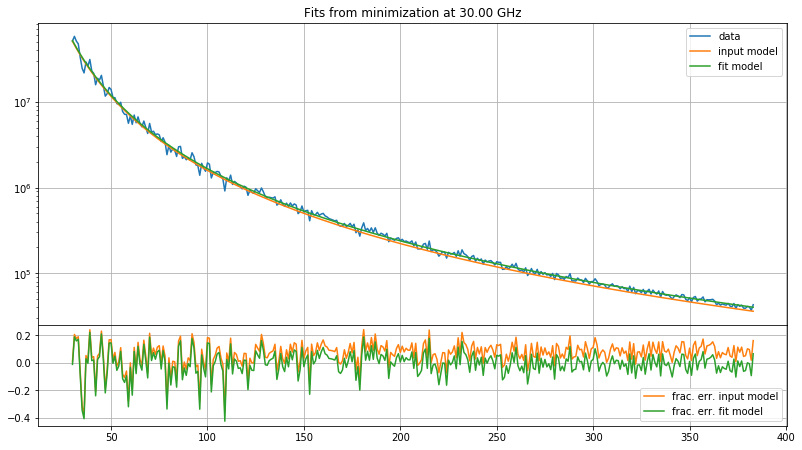

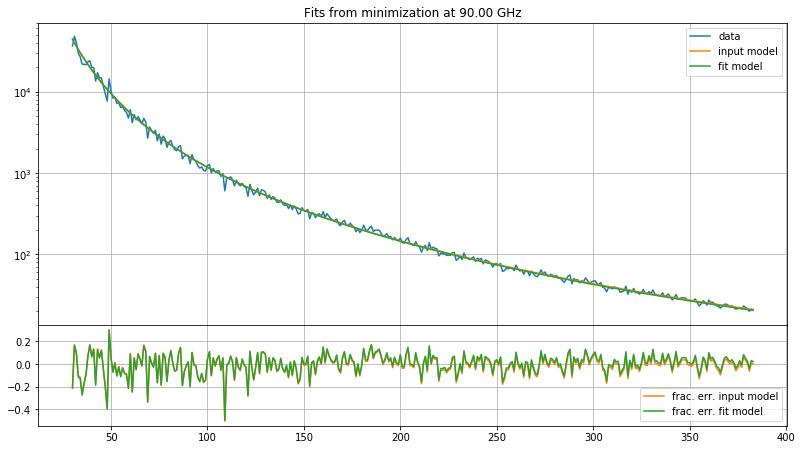

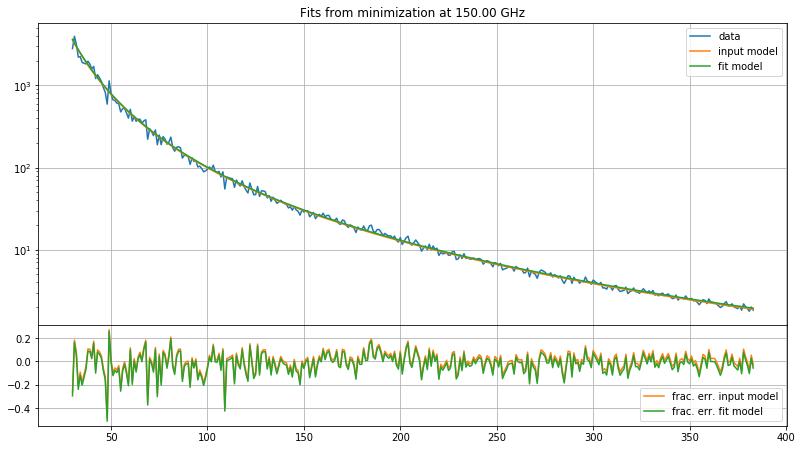

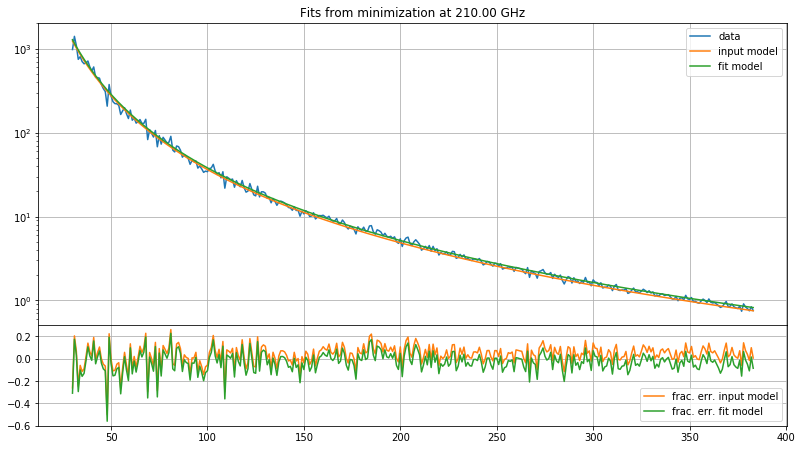

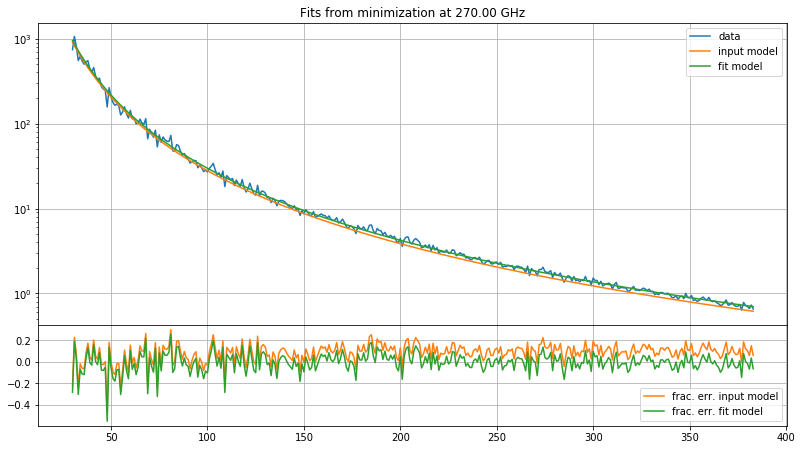

In [18]:
for i in range(len(freqs)):
    if i%2==0: #reduce number of plots
        fig1 = figure(figsize=(13,7))
        frame1=fig1.add_axes((.1,.3,.8,.6))
        frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
        semilogy(ells[30:], data[i][30:], label='data')
        semilogy(ells[30:], in_model[i][30:], label='input model', color='C1')
        semilogy(ells[30:], fit0[i][30:], label='fit model', color='C2')
        grid()
        title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
        legend()



        frame2=fig1.add_axes((.1,.1,.8,.2)) 
        plot(ells[30:], (data[i][30:]-in_model[i][30:])/data[i][30:],
             color='C1', label='frac. err. input model')
        plot(ells[30:], (data[i][30:]-fit0[i][30:])/data[i][30:],
             color='C2', label='frac. err. fit model')
        legend()
        grid()

In [ ]:
#the log likilihood is the same as chi2 in this case

In [253]:
#now let's add priors, we'll start with flat priors everywhere
def log_prior(params):
    A, alpha, beta, gamma = params
    if 1. < A < 1.e4 and -6.0 < alpha < 0.0 and -6.0 < beta < 0.0 and -6.0 < gamma < -2.0:
        return 0.0
    return -np.inf

In [254]:
def log_probability(params, ells, freqs, data):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ff.chi2(params, ells, freqs, data)

In [266]:
start=time.time()
pos = soln.x + 1e-4*np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ells, freqs, data), threads=4)
sampler.run_mcmc(pos, 100, progress='notebook');
print(time.time()-start)


91.4202651977539


In [258]:
#so each step takes ~10 seconds, this is not ideal as we want to do 5000 steps which would be 14 hours
#model generation takes .3 seconds and we're running 32 walkers, so ~10 sec per step of the chain.

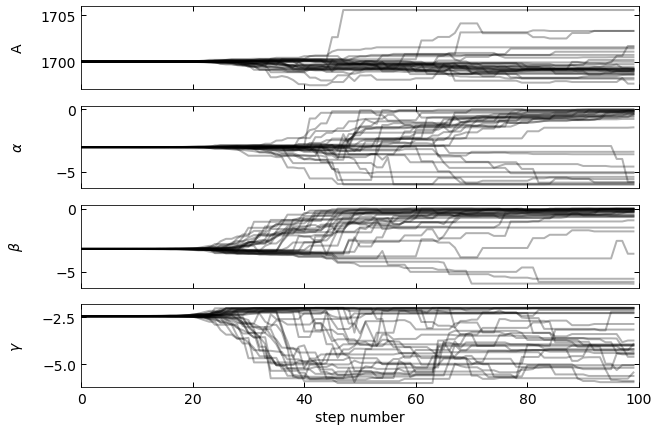

In [259]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A", r"$\alpha$", r"$\beta$", r"$\gamma$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [260]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [11.91248707 12.53777023 12.94100597 10.70569888]

In [261]:
flat_samples = sampler.get_chain(thin=5, flat=True) # should discard the first 100 or something steps of the chain
#do this with discard=100
print(flat_samples.shape)

(640, 4)


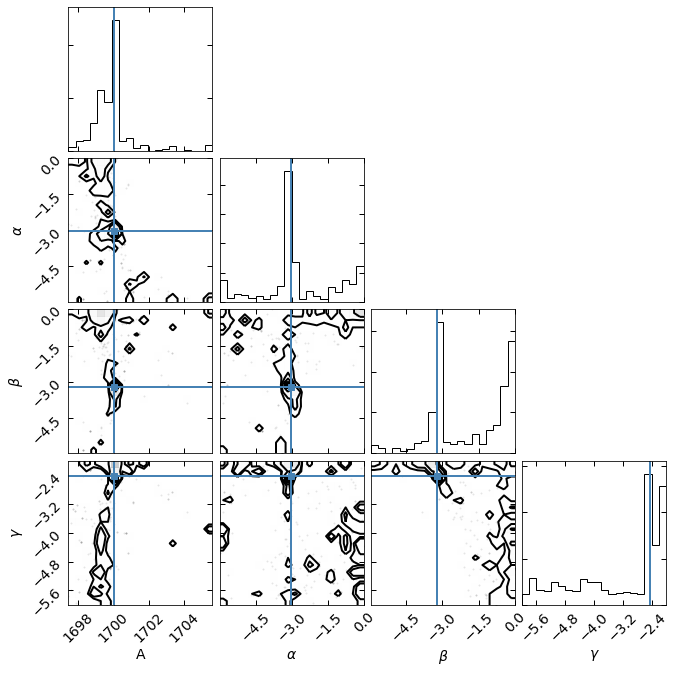

In [262]:
fig = corner.corner(flat_samples, labels=labels, truths=x0);

In [44]:
%autoreload

In [59]:
#let's make this faster by just cutting calculation of 1x1 moment down. (use smaller ell max in wignersum)

In [267]:
#proceeding as above but only calculating the wignersum up to 384 instead of to 768.
start=time.time()
pos1 = soln.x + 1e-4*np.random.randn(32, 4)
nwalkers1, ndim1 = pos1.shape

sampler1 = emcee.EnsembleSampler(nwalkers1, ndim1, log_probability, args=(ells, freqs, data), threads=8)
sampler1.run_mcmc(pos1, 1000, progress='notebook');
print(time.time()-start)


729.3613829612732


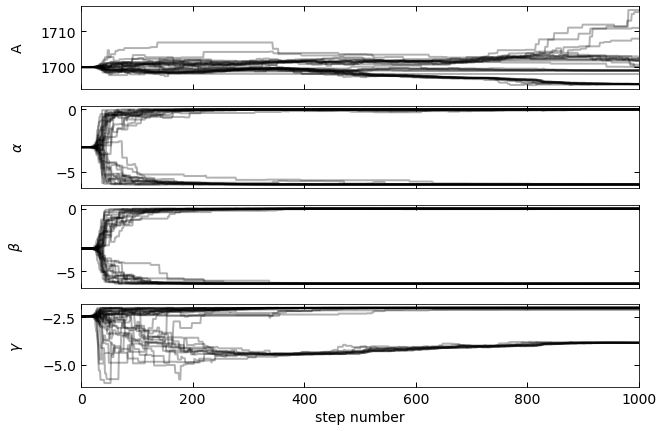

In [269]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples1 = sampler1.get_chain()
labels = ["A", r"$\alpha$", r"$\beta$", r"$\gamma$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples1[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples1))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [270]:
tau = sampler1.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [127.07828149  69.69120646  69.49337964  93.04273632]

In [271]:
flat_samples1 = sampler1.get_chain(thin=25, flat=True) # should discard the first 100 or something steps of the chain
#do this with discard=100
print(flat_samples.shape)

(640, 4)


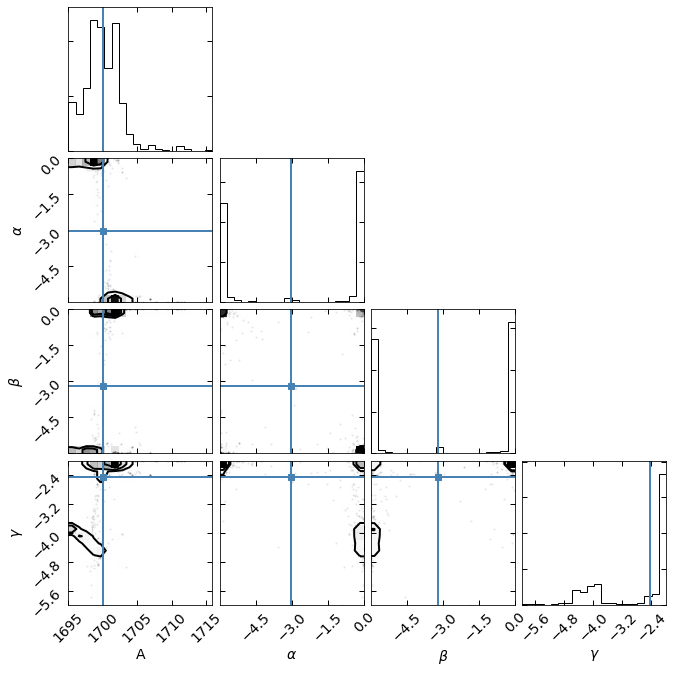

In [272]:
fig = corner.corner(flat_samples1, labels=labels, truths=x0);

In [60]:
#check how long the ML estimate takes with the reduced wignersum length
#the log likelihood for our stuff is simply the chi2 with cosmic variance errors
#find the placement of maximum likelihood
start=time.time()
soln1 = minimize(ff.chi2, input_params, args=(ells, freqs, data), 
                   method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (-6.0, -2.01)))
print(soln1)
print(time.time()-start)

      fun: 3985.733960404864
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.74405762,  0.00609361,  0.05134098, -0.01082299])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 65
      nit: 10
   status: 0
  success: True
        x: array([1700.00004004,   -3.01146884,   -3.19363583,   -2.43477816])
4.118159055709839


In [64]:
print((soln1.x-x0)/x0*100)

[-2.00453777e-07 -8.53728299e-02  8.99411222e-03 -2.48820627e-01]


In [62]:
#okay, so the errors in ML are only in parts 1 in 1000 in gamma and alpha, so we can probably use the shorter
#sum to work with the faster times acceptably.

In [65]:
#let's try different priors?

In [66]:
#priors with different ranges
def log_prior(params):
    A, alpha, beta, gamma = params
    if 0.5e3 < A < 3e3 and -4.0 < alpha < -2.0 and -4.0 < beta < -2.0 and -4.0 < gamma < -2.0:
        return 0.0
    return -np.inf

In [67]:
start=time.time()
pos2 = soln.x + 1e-4*np.random.randn(32, 4)
nwalkers2, ndim2 = pos2.shape

sampler2 = emcee.EnsembleSampler(nwalkers2, ndim2, log_probability, args=(ells, freqs, data))
sampler2.run_mcmc(pos2, 1000, progress='notebook');
print(time.time()-start)


1161.6846089363098


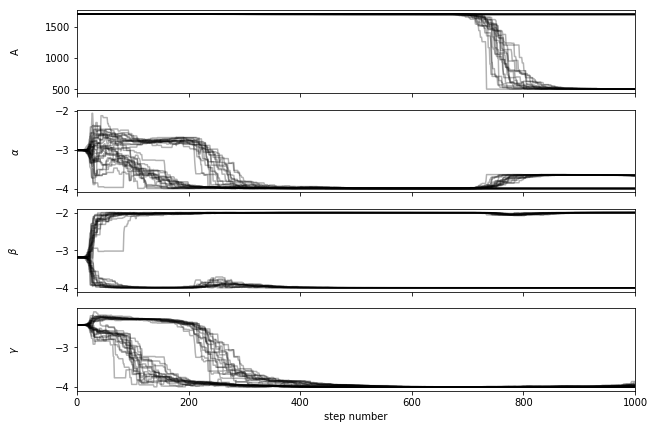

In [72]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples2 = sampler2.get_chain()
labels = ["A", r"$\alpha$", r"$\beta$", r"$\gamma$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples2))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [73]:
#so seems to like wandering off to the bounds of the flat priors? Weird. I've seen this sort of behaviour 
#with gamma before when running the minimizers. Beta seems to be the most affected, it diverges to its bounds
#very quickly

In [70]:
flat_samples2 = sampler2.get_chain(thin=25, flat=True) # should discard the first 100 or something steps of the chain
#do this with discard=100
print(flat_samples2.shape)

(1280, 4)


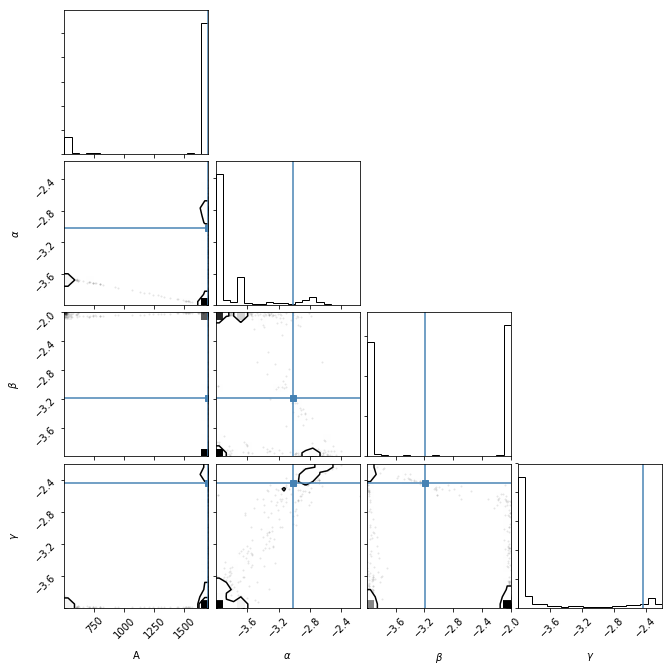

In [71]:
fig = corner.corner(flat_samples2, labels=labels, truths=x0);

In [79]:
%autoreload

In [80]:
%timeit ff.model(ells, freqs, input_params)

53.5 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [81]:
start=time.time()

sampler3 = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ells, freqs, data))
sampler3.run_mcmc(pos, 1000, progress='notebook');
print(time.time()-start)

emcee: Exception while calling your likelihood function:
  params: [1700.00164842   -3.01360727   -3.19397649   -2.44047883]
  args: (array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
  

Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/emcee-3.0rc2-py3.7.egg/emcee/ensemble.py", line 499, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-20-7a2a78e56d54>", line 5, in log_probability
    return lp + ff.chi2(params, ells, freqs, data)
  File "/Users/alex/Documents/foreground_moments/foreground_functions.py", line 266, in chi2
    model_made = model(ells, freqs, params)
  File "/Users/alex/Documents/foreground_moments/foreground_functions.py", line 256, in model
    mom1x1 = auto1x1(ells, freqs, params)
  File "/Users/alex/Documents/foreground_moments/foreground_functions.py", line 214, in auto1x1
    wignersum = get_wigner_sum(ells, params)
  File "/Users/alex/Documents/foreground_moments/foreground_functions.py", line 200, in get_wigner_sum
    wignersum = np.einsum("i,i,j,j,kij", f, amp_cls, f, beta_cls, w3j1, optimize=True)
  File "/anaconda3/lib/python3.7/site-packages/numpy/core/einsumfunc.py", line 14

KeyboardInterrupt: 

In [82]:
%timeit log_probability(input_params, ells, freqs, data)

52.7 ms ± 925 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [83]:
%lprun -f log_probability log_probability(input_params, ells, freqs, data)

In [85]:
%lprun -f ff.chi2 ff.chi2(input_params, ells, freqs, data)

In [87]:
%lprun -f ff.model ff.model(ells, freqs, input_params)

In [88]:
%lprun -f ff.auto1x1 ff.auto1x1(ells, freqs, input_params)

In [89]:
%lprun -f ff.get_wigner_sum ff.get_wigner_sum(ells, input_params)

In [106]:
%timeit ff.get_wigner_sum(ells, input_params)

52.7 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [100]:
%autoreload

In [96]:
%timeit ff.get_wigner_sum(ells, input_params)

64.5 ms ± 5.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [109]:
#the log likelihood for our stuff is simply the chi2 with cosmic variance errors
#find the placement of maximum likelihood
start=time.time()
soln1 = minimize(ff.chi2, [1e3, -1.0, -1.0, -4.0], args=(ells, freqs, data), 
                   method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (-6.0, -2.01)))
print(soln1)
print(time.time()-start)

      fun: 3981.924467121544
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.09494702e-05, -3.36513040e-02,  6.20275387e-02,  7.89441401e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 490
      nit: 69
   status: 0
  success: True
        x: array([1710.2915411 ,   -3.01538866,   -3.19386952,   -2.44011863])
25.97066020965576


In [114]:
mom0x0 = ff.auto0x0(ells, freqs, input_params[:-1])

In [218]:
rcParams['lines.linewidth'] = 2
    
lsize = 14
rcParams['xtick.labelsize'] = lsize
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 5
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1
rcParams['xtick.bottom'] = True
rcParams['xtick.top'] = True
rcParams['xtick.direction'] = 'in'


rcParams['ytick.labelsize'] = lsize
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 5
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1
rcParams['ytick.left'] = True
rcParams['ytick.right'] = True
rcParams['ytick.direction'] = 'in'


rcParams['legend.fontsize'] = 14
rcParams['legend.borderaxespad'] = 1

rcParams['axes.labelsize'] = lsize
rcParams['axes.titlesize'] = lsize
# figsize=(15, 12)

In [219]:
from matplotlib.lines import Line2D

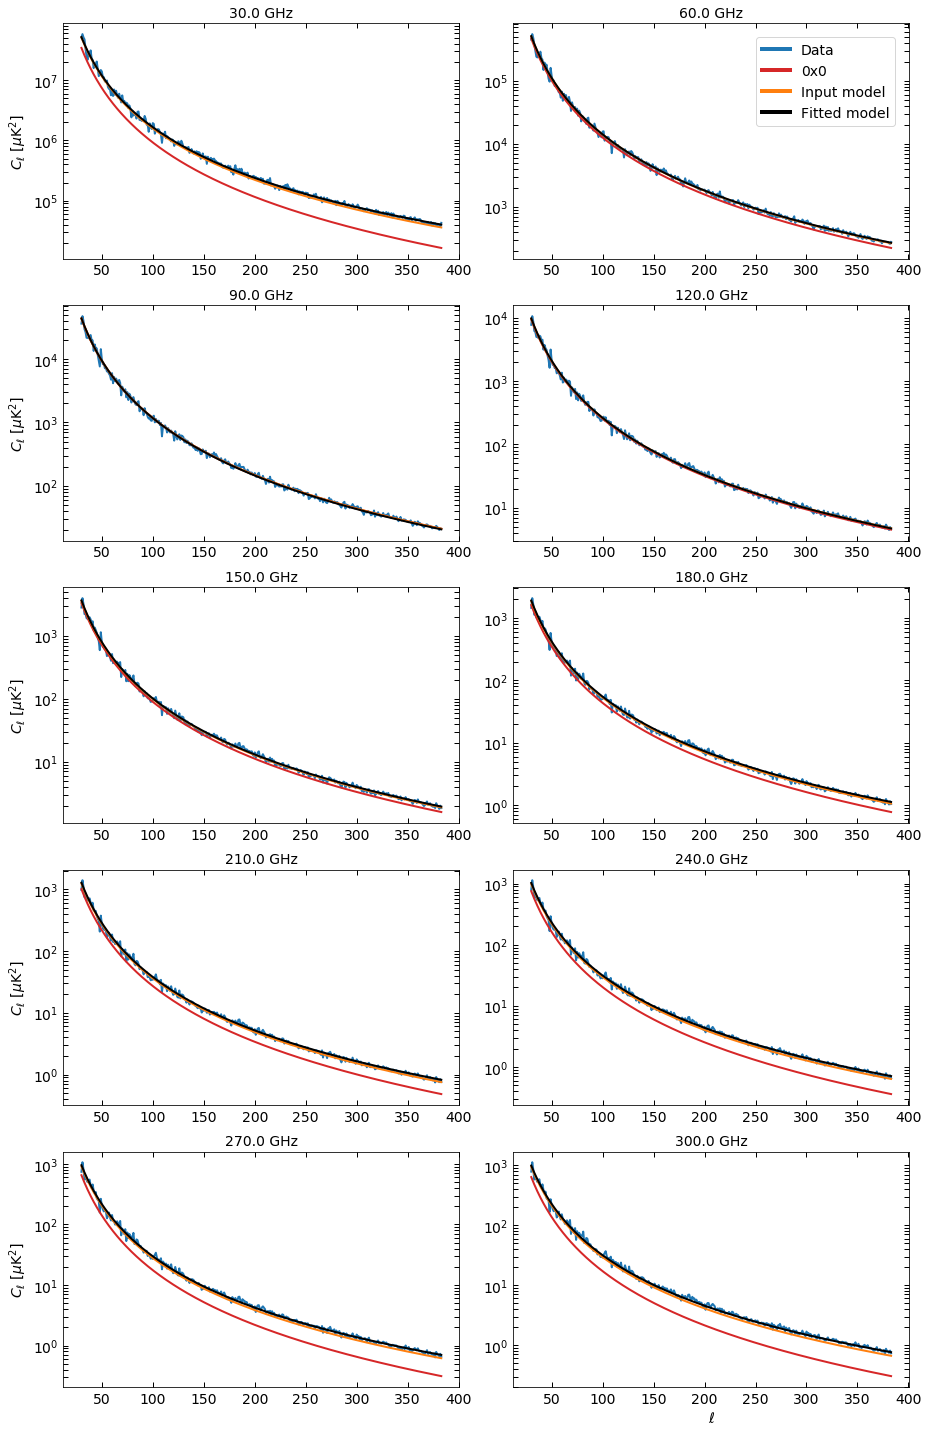

In [234]:
fig, ax = subplots(5,2, figsize=(13,20))
for i in range(len(freqs)):
    subplot(5,2,i+1)
    semilogy(ells[30:], data[i][30:], label='data', color='C0')
    semilogy(ells[30:], mom0x0[i][30:], label='mom0x0', color='C3')
    semilogy(ells[30:], in_model[i][30:], label='input model', color='C1')
    semilogy(ells[30:], fit0[i][30:], label='fit model', color='k')
    title('{:.1f} GHz'.format(freqs[i]/1e9))
    if i>8: 
        xlabel(r'$\ell$')
    if i%2==0:
        ylabel(r'$C_\ell \ [\mu \mathrm{K}^2]$')

    tight_layout()
    if i==1:
        legend_elements = [Line2D([0], [0], color='C0', lw=4, label='Data'),
                          Line2D([0], [0], color='C3', lw=4, label='0x0'),
                          Line2D([0], [0], color='C1', lw=4, label='Input model'),
                          Line2D([0], [0], color='k', lw=4, label='Fitted model')]
        legend(handles=legend_elements, ncol=1, loc='upper right')
# savefig('fits.png', dpi=300, transparent=True)

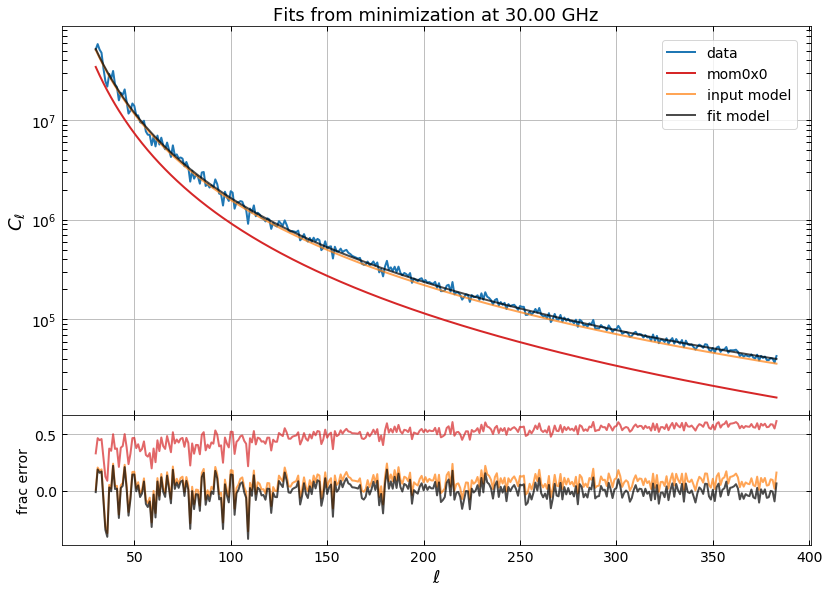

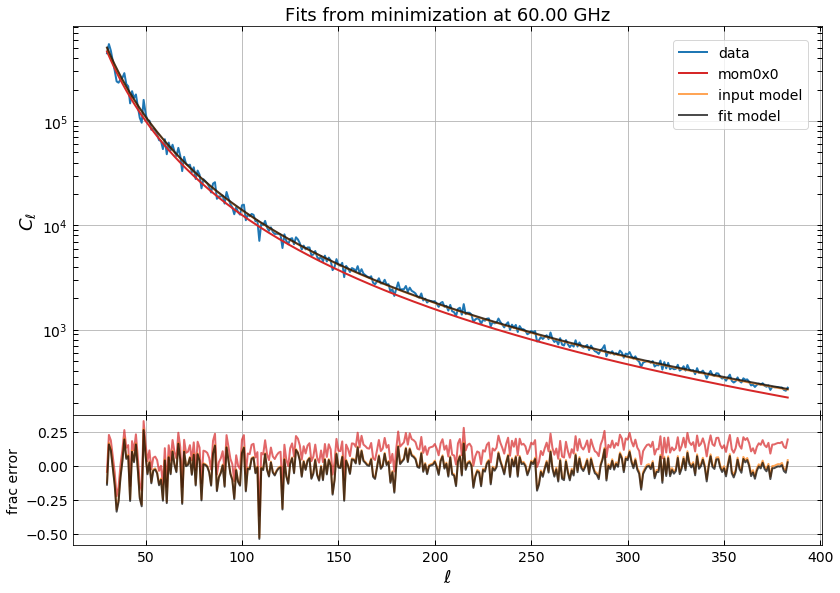

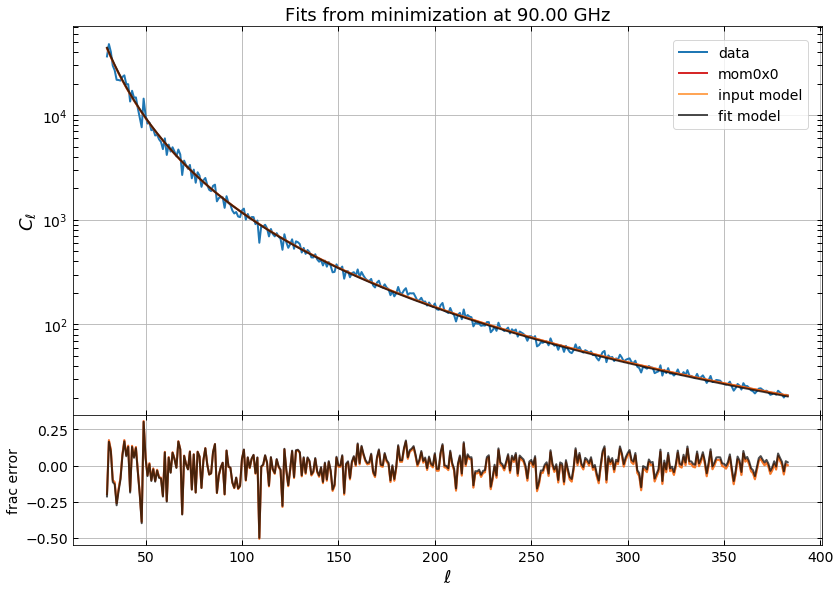

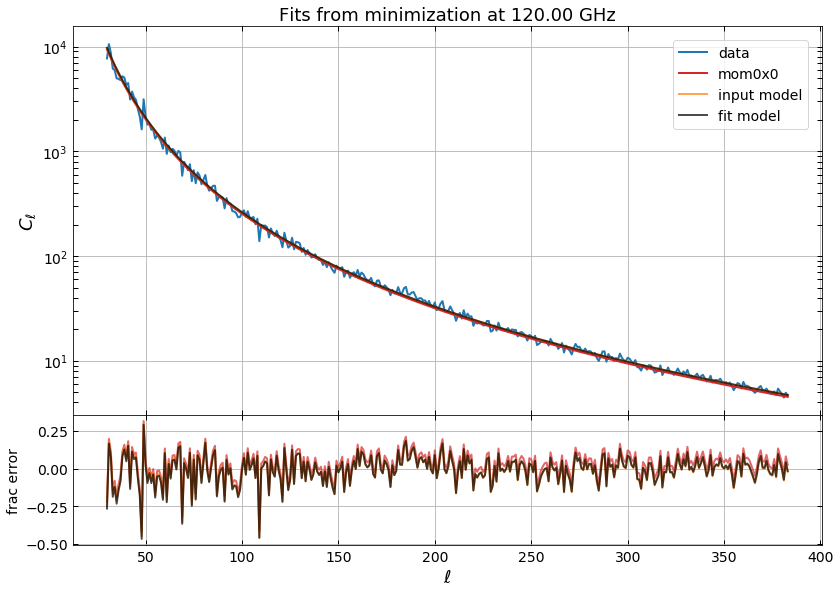

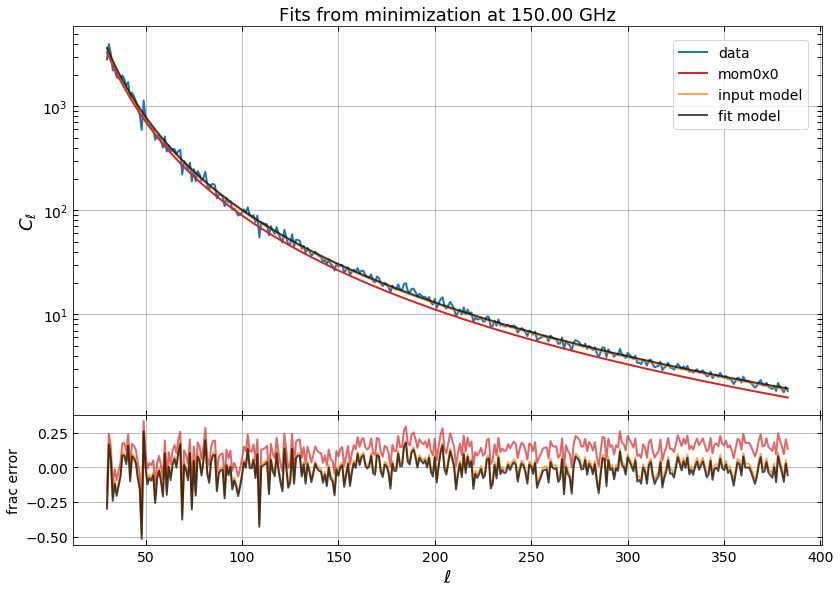

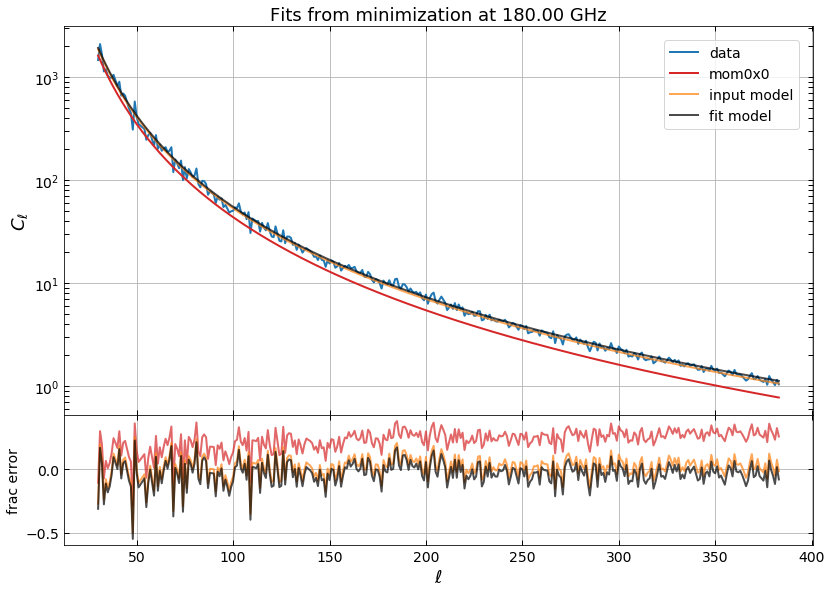

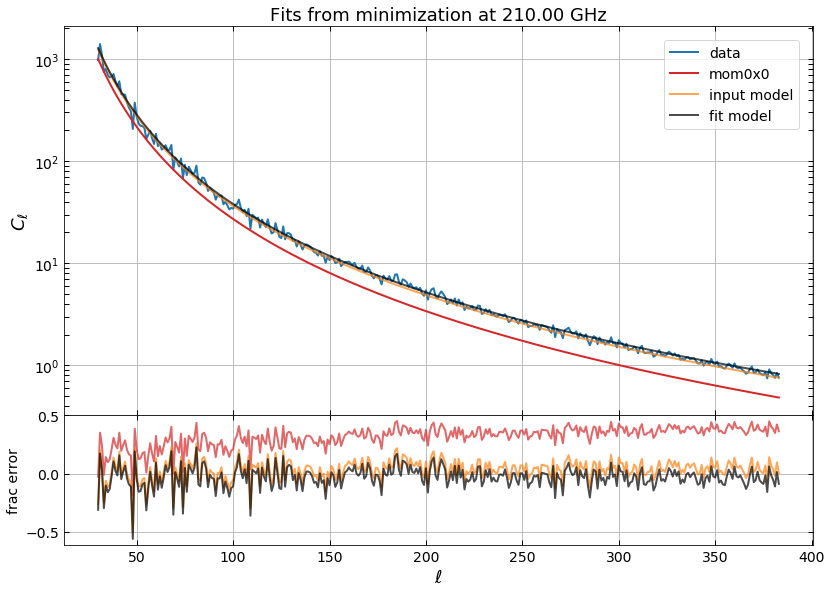

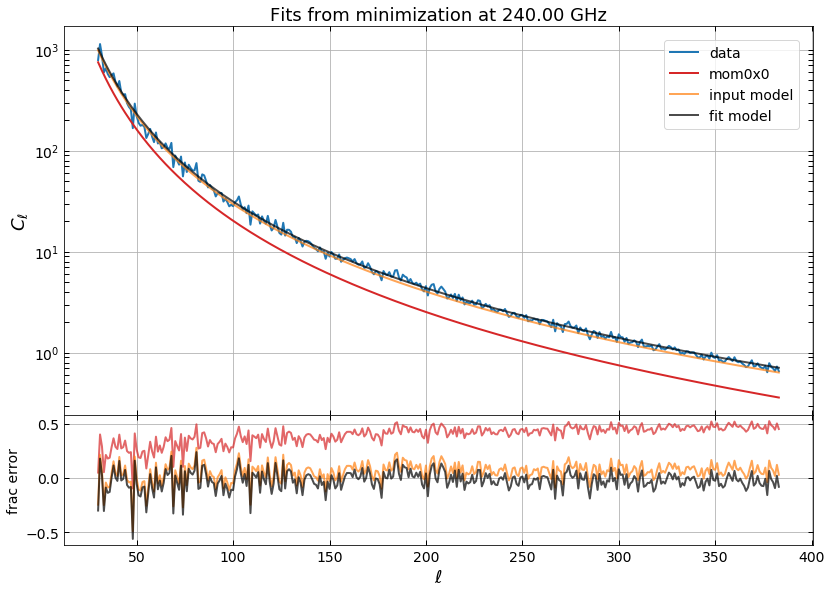

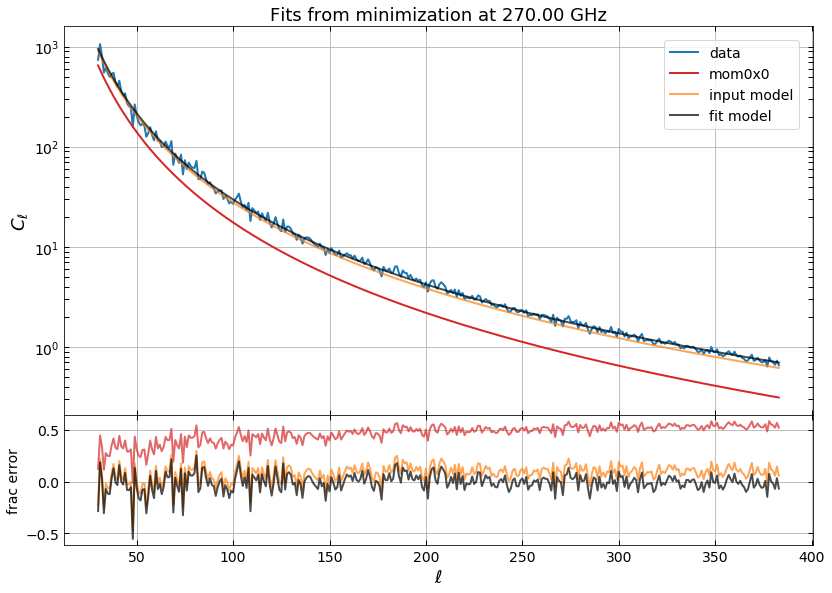

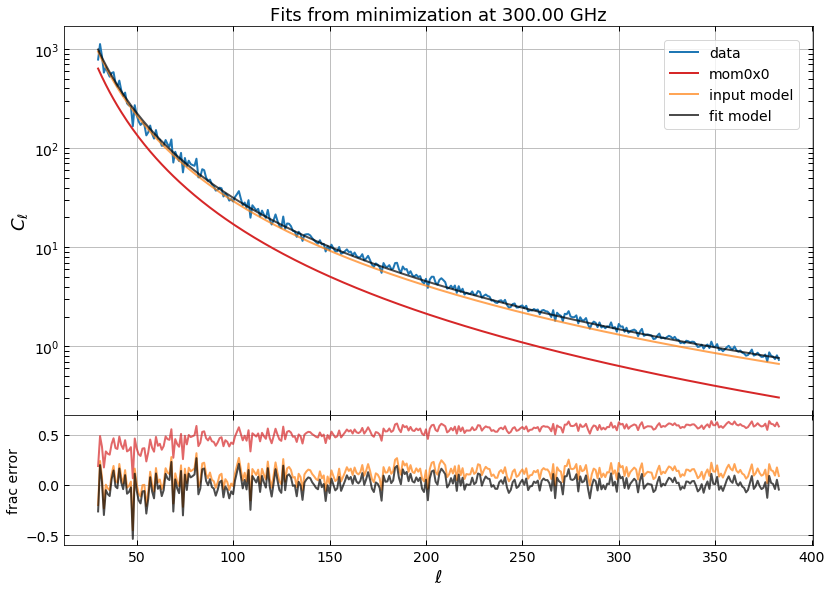

In [236]:
for i in range(len(freqs)):
    fig1 = figure(figsize=(13,9))
    frame1=fig1.add_axes((.1,.3,.8,.6))
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    semilogy(ells[30:], data[i][30:], label='data', color='C0')
    semilogy(ells[30:], mom0x0[i][30:], label='mom0x0', color='C3')
    semilogy(ells[30:], in_model[i][30:], label='input model', color='C1', alpha=0.7)
    semilogy(ells[30:], fit0[i][30:], label='fit model', color='k', alpha=0.7)
    grid()
    ylabel(r'$C_\ell$', fontsize=18)
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9), fontsize=18)
    legend()

    frame2=fig1.add_axes((.1,.1,.8,.2)) 
    plot(ells[30:], (data[i][30:]-mom0x0[i][30:])/data[i][30:],
         color='C3', label='frac. err. mom0x0', alpha=0.7)
    plot(ells[30:], (data[i][30:]-in_model[i][30:])/data[i][30:],
         color='C1', label='frac. err. input model', alpha=0.7)
    plot(ells[30:], (data[i][30:]-fit0[i][30:])/data[i][30:],
         color='k', label='frac. err. fit model', alpha=0.7)
    xlabel(r'$\ell$',fontsize=18)
    ylabel('frac error')
    grid()


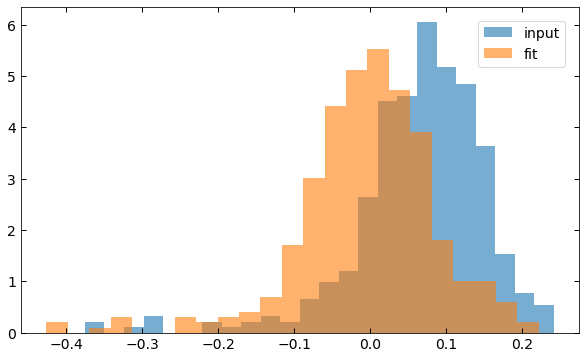

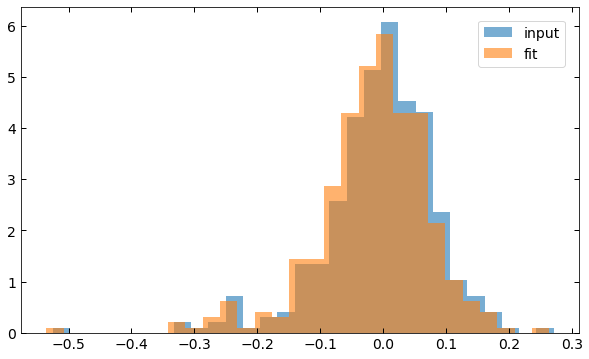

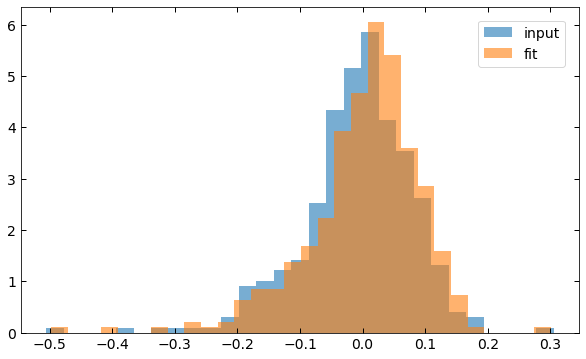

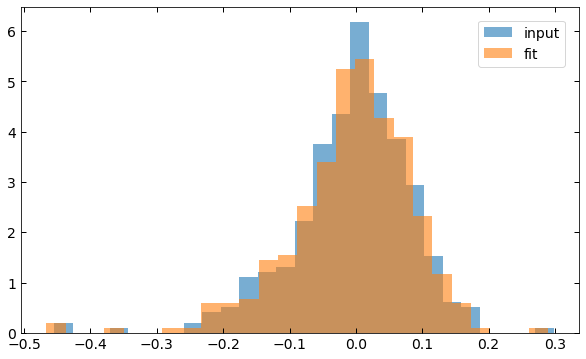

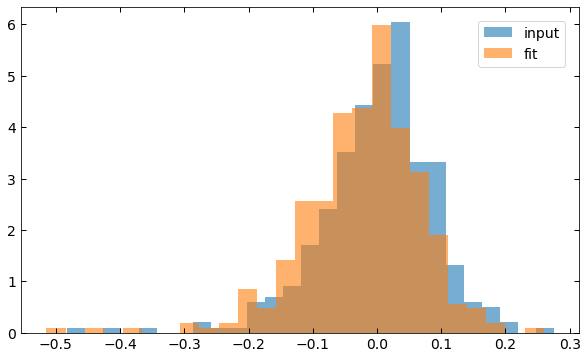

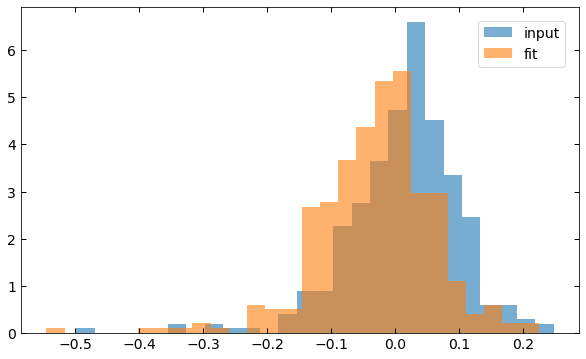

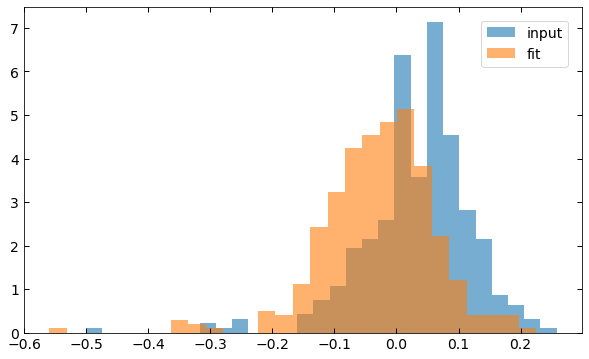

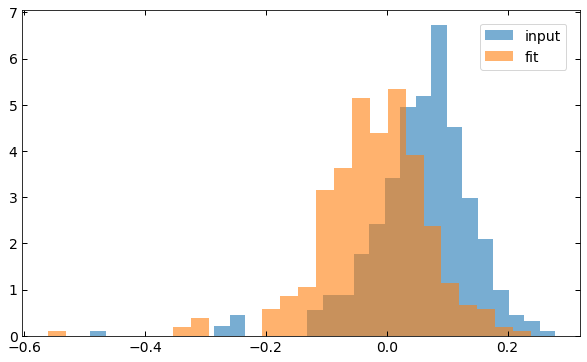

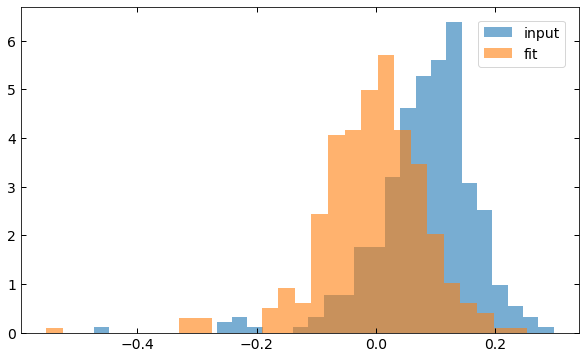

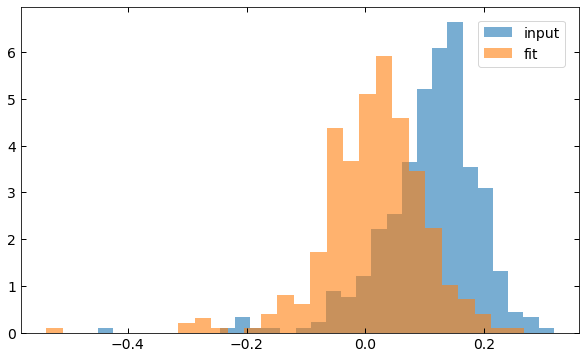

In [245]:
#histograms of the errors?
for i in range(len(freqs)):
    figure(figsize=(10,6))
    hist((data[i][30:]-in_model[i][30:])/data[i][30:], density=True, alpha=0.6, label='input', bins='auto');
    hist((data[i][30:]-fit0[i][30:])/data[i][30:], density=True, alpha=0.6, label='fit',bins='auto');
    legend();

In [250]:
for i in range(len(freqs)):
    print(np.mean((data[i][30:]-in_model[i][30:])/data[i][30:]), np.mean((data[i][30:]-fit0[i][30:])/data[i][30:]))

0.06447533212281045 -0.004470572284079572
-0.005524205977569917 -0.01610304538341725
-0.008150153930487463 0.003005149900841009
-0.006460648941173423 -0.006679269965635974
0.0004057800917709471 -0.022219043342562025
0.014078379314607445 -0.030582826094032955
0.03341604092386687 -0.029446997508376187
0.056590460880541774 -0.0203138309070554
0.08201506684132726 -0.005362367551503322
0.10852528961454001 0.013510033115406748
